In [1]:
using Graphs
using RNAStructPlot
using CairoMakie

sequence = "CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAU"
notation = "(((((((..((((((.........))))))......).((((((.......))))))..))))))"

# sequence = "AAAAAAAAAAAAAAAAAA"
# notation = ".((.((((..)).))))."

"(((((((..((((((.........))))))......).((((((.......))))))..))))))"

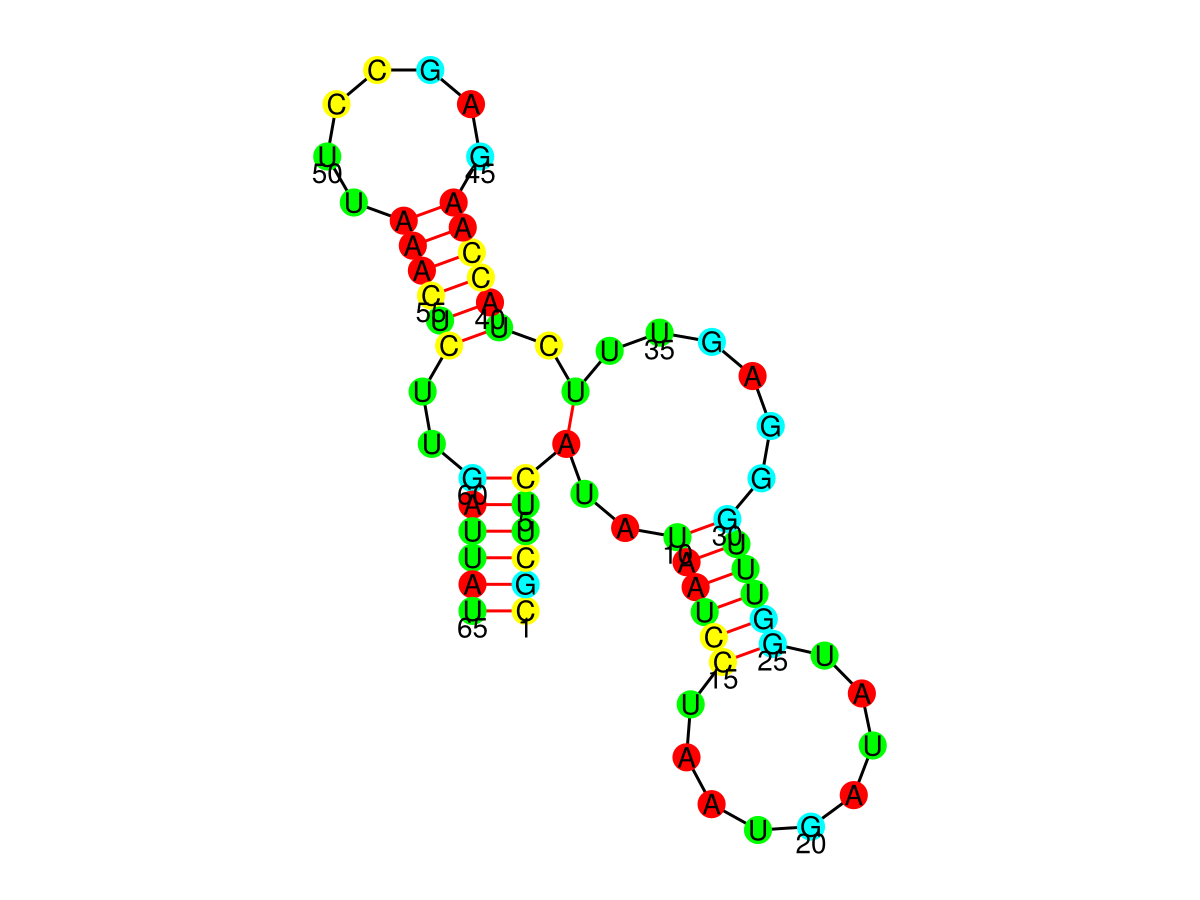

In [2]:
using RNAStructPlot

rnatree = dotbrackettree(sequence, notation)
rnabase = dotbracketbase(sequence, notation)

coords = drawpolygonal(rnatree)

draw_final(rnabase.graph, coords, rnabase.nucleotides, rnabase.pairings)